In [1]:
# modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pickle import dump
%matplotlib inline


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV

# models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Loading Data 

In [2]:
DATA_DIR = 'binary_classifier_data/'

train_ds = pd.read_csv(os.path.join(DATA_DIR, 'training.csv'), delimiter=';', decimal=',')
valid_ds = pd.read_csv(os.path.join(DATA_DIR, 'validation.csv'), delimiter=';', decimal=',')

In [3]:
train_ds.shape, valid_ds.shape

((3700, 19), (200, 19))

In [4]:
train_ds.head()

,variable1,variable2,variable3,variable4,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12,variable13,variable14,variable15,variable17,variable18,variable19,classLabel
0,a,17.92,0.000054,u,g,c,v,1.750,f,t,1,t,g,80.0,5,800000.0,t,0,no.
1,b,16.92,0.000034,y,p,k,v,0.290,f,f,0,f,s,200.0,0,2000000.0,NaN,0,no.
2,b,31.25,0.000112,u,g,ff,ff,0.000,f,t,1,f,g,96.0,19,960000.0,t,0,no.
3,a,48.17,0.000133,u,g,i,o,0.335,f,f,0,f,g,0.0,120,0.0,NaN,0,no.
4,b,32.33,0.000350,u,g,k,v,0.500,f,f,0,t,g,232.0,0,2320000.0,f,0,no.


In [5]:
train_ds.dtypes

variable1      object
variable2     float64
variable3     float64
variable4      object
variable5      object
variable6      object
variable7      object
variable8     float64
variable9      object
variable10     object
variable11      int64
variable12     object
variable13     object
variable14    float64
variable15      int64
variable17    float64
variable18     object
variable19      int64
classLabel     object
dtype: object

In [6]:
# Getting numeric and categorical features
numerical = []
categorical = []

features = dict(train_ds.dtypes)

for feature in features:
    if str(features[feature]) == 'object':
        categorical.append(feature)
    else:
        numerical.append(feature)
        
print('Numerical Features:\n', numerical)
print('Categorical Features:\n', categorical)

Numerical Features:
 ['variable2', 'variable3', 'variable8', 'variable11', 'variable14', 'variable15', 'variable17', 'variable19']
Categorical Features:
 ['variable1', 'variable4', 'variable5', 'variable6', 'variable7', 'variable9', 'variable10', 'variable12', 'variable13', 'variable18', 'classLabel']


In [7]:
# checking the unique values for the categorical features
for col in categorical:
    print(col, ':')
    print(train_ds[col].unique())

variable1 :
['a' 'b' nan]
variable4 :
['u' 'y' nan 'l']
variable5 :
['g' 'p' nan 'gg']
variable6 :
['c' 'k' 'ff' 'i' 'j' 'q' 'W' 'd' 'm' 'cc' 'aa' 'r' 'x' 'e' nan]
variable7 :
['v' 'ff' 'o' 'h' 'j' 'bb' 'n' 'z' nan 'dd']
variable9 :
['f' 't']
variable10 :
['t' 'f']
variable12 :
['t' 'f']
variable13 :
['g' 's' 'p']
variable18 :
['t' nan 'f']
classLabel :
['no.' 'yes.']


In [8]:
# missing values per column
print('Missing values per column:')
train_ds.isna().sum()

Missing values per column:


variable1       39
variable2       39
variable3        0
variable4       64
variable5       64
variable6       66
variable7       66
variable8        0
variable9        0
variable10       0
variable11       0
variable12       0
variable13       0
variable14     100
variable15       0
variable17     100
variable18    2145
variable19       0
classLabel       0
dtype: int64

# Preprocessing Pipelinee
### Handling Missing Data
- `variable18` has a very high number of missing values, 57% -> will be removed
- Impute the categorical features with mode
- Impute the numerical features with median

### Encoding the Categorical Features
- Categorical features -> Onehotencoder
- Target Column -> Label encoding

In [9]:
# drop variable18
train_ds.drop('variable18', axis=1, inplace=True)
if 'variable18' in categorical: categorical.remove('variable18')

In [10]:
target_col = ['classLabel']
# remove the target column from the categorical list
if 'classLabel' in categorical: categorical.remove('classLabel')

In [11]:
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [12]:
numerical.remove('variable19')
preprocess_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, numerical),
    ('categoric', cat_pipeline, categorical)
], remainder='passthrough')

labelencoder = LabelEncoder()

In [13]:
train_y = train_ds.classLabel
train_ds_x = train_ds.drop('classLabel', axis=1)
X_train = preprocess_pipeline.fit_transform(train_ds_x)
y_train = labelencoder.fit_transform(train_y)

In [14]:
# Saving the process pipeline for prediction script
dump(preprocess_pipeline, open('preprocess_pipeline.pkl', 'wb'))
dump(labelencoder, open('labelencoder.pkl', 'wb'))

(276, 3424)

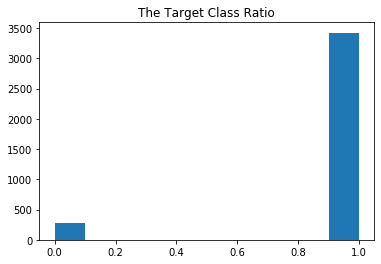

In [15]:
# the ratio of the target class
plt.hist(y_train)
plt.title("The Target Class Ratio")
plt.plot()
(y_train==0).sum(), (y_train==1).sum()

In [16]:
3424/train_ds.shape[0]

0.9254054054054054

In [17]:
X_train.shape

(3700, 48)

In [18]:
train_ds.shape

(3700, 18)

# Transfrom the validationset 

In [19]:
# drop variable18
valid_ds.drop('variable18', axis=1, inplace=True)

valid_y = valid_ds.classLabel
valid_ds_x = valid_ds.drop('classLabel', axis=1)
X_valid = preprocess_pipeline.transform(valid_ds_x)
y_valid = labelencoder.fit_transform(valid_y)

In [20]:
# the ratio of the target class
(y_valid==0).sum(), (y_valid==1).sum()

(107, 93)

# Choosing the Performance Metrics 
- As the data is imbalanced, I'm not going to depend mainly on `accuracy` as my performance metrics
- But I will also be using the confusion matrix, precission, recall and F1 as it will yield in better understanding

# Training different models

In [21]:
def show_results(model, x, y):
    
    # making prediction
    predicted = pd.DataFrame(model.predict(x))    
    # performance metrics
    accuracy = metrics.accuracy_score(y, predicted)       
    precision = metrics.precision_score(y, predicted, pos_label=1)
    recall = metrics.recall_score(y, predicted, pos_label=1)
    f1 = metrics.f1_score(y, predicted, pos_label=1)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    plot_cm(model, x, y)
    return accuracy, precision, recall, f1
def plot_cm(model, x, y):
    metrics.plot_confusion_matrix(model, x, y)
    plt.plot()

Training Accuracy: 1.0
____________________
Validation Results
Accuracy: 0.5
Precision: 0.46534653465346537
Recall: 0.5053763440860215
F1: 0.48453608247422686


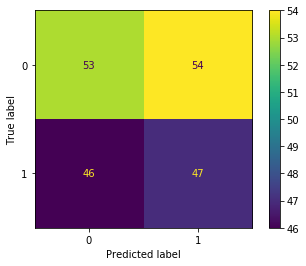

In [22]:
# SVC
svm_model = SVC(probability=True)
svm_model = svm_model.fit(X_train, y_train)

svm_acc_t = metrics.accuracy_score(y_train, svm_model.predict(X_train))
print(f'Training Accuracy: {svm_acc_t}')
print('_'*20)
print('Validation Results')
svm_acc, svm_precision, svm_recall, svm_f1 = show_results(svm_model, X_valid, y_valid)

Training Accuracy: 1.0
____________________
Validation Results
Accuracy: 0.495
Precision: 0.46
Recall: 0.4946236559139785
F1: 0.4766839378238342


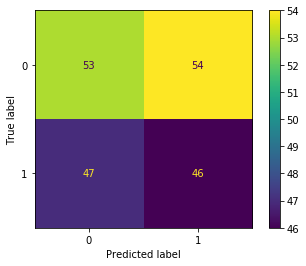

In [23]:
# Decision Tree
tree_model = DecisionTreeClassifier()
parameters_dt = {"criterion": ["gini", "entropy"], "splitter": ["best", "random"], "max_features": ["auto", "sqrt", "log2"], 'max_depth': [3, 5, 7]}

grid_dt = GridSearchCV(tree_model, parameters_dt, scoring=make_scorer(accuracy_score))
grid_dt.fit(X_train, y_train)

tree_model = grid_dt.best_estimator_

tree_acc_t = metrics.accuracy_score(y_train, tree_model.predict(X_train))
print(f'Training Accuracy: {tree_acc_t}')
print('_'*20)
print('Validation Results')
tree_acc, tree_precision, tree_recall, tree_f1 = show_results(tree_model, X_valid, y_valid)

Training Accuracy: 0.9986486486486487
____________________
Validation Results
Accuracy: 0.63
Precision: 0.576
Recall: 0.7741935483870968
F1: 0.6605504587155964


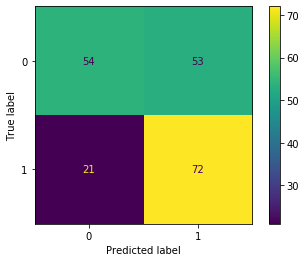

In [24]:
# Random Forest
rf_model = RandomForestClassifier()
parameters_rf = {"n_estimators": [4, 5, 6, 7, 8, 9, 10, 15], "criterion": ["gini", "entropy"], "max_features": ["auto", "sqrt", "log2"], 
                 "max_depth": [2, 3, 5, 10], "min_samples_split": [2, 3, 5, 10]}

grid_rf = GridSearchCV(rf_model, parameters_rf, scoring=make_scorer(accuracy_score))
grid_rf.fit(X_train, y_train)

rf_model = grid_rf.best_estimator_
rf_model.fit(X_train, y_train)

rf_acc_t = metrics.accuracy_score(y_train, rf_model.predict(X_train))
print(f'Training Accuracy: {rf_acc_t}')
print('_'*20)
print('Validation Results')
rf_acc, rf_precision, rf_recall, rf_f1 = show_results(rf_model, X_valid, y_valid)

Training Accuracy: 1.0
____________________
Validation Results
Accuracy: 0.74
Precision: 0.7070707070707071
Recall: 0.7526881720430108
F1: 0.7291666666666666


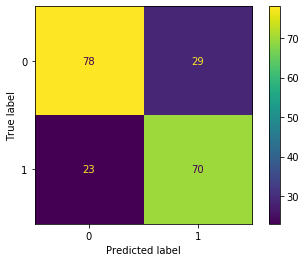

In [25]:
# KNN
knn_model = KNeighborsClassifier()
parameters_knn = {"n_neighbors": [2, 3, 5, 10, 15], "weights": ["uniform", "distance"], "algorithm": ["auto", "ball_tree", "kd_tree"],
                  "leaf_size": [5 ,10, 20, 30, 50]}

grid_knn = GridSearchCV(knn_model, parameters_knn, scoring=make_scorer(precision_score))
grid_knn.fit(X_train, y_train)

knn_model = grid_knn.best_estimator_

knn_acc_t = metrics.accuracy_score(y_train, knn_model.predict(X_train))
print(f'Training Accuracy: {knn_acc_t}')
print('_'*20)
print('Validation Results')
knn_acc, knn_precision, knn_recall, knn_f1 = show_results(knn_model, X_valid, y_valid)

Training Accuracy: 0.9986486486486487
____________________
Validation Results
Accuracy: 0.495
Precision: 0.46
Recall: 0.4946236559139785
F1: 0.4766839378238342


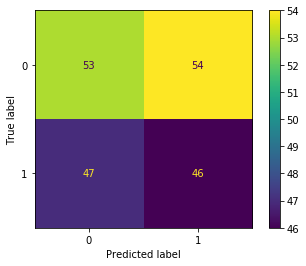

In [26]:
# XGBoost
from xgboost import XGBClassifier

xg_model = XGBClassifier()

parameters_xg = {"n_estimators" : [5, 10, 15, 20]}

grid_xg = GridSearchCV(xg_model, parameters_xg, scoring=make_scorer(precision_score))
grid_xg.fit(X_train, y_train)

xg_model = grid_xg.best_estimator_

xg_acc_t = metrics.accuracy_score(y_train, xg_model.predict(X_train))
print(f'Training Accuracy: {rf_acc_t}')
print('_'*20)
print('Validation Results')
xg_acc, xg_precision, xg_recall, xg_f1 = show_results(xg_model, X_valid, y_valid)

In [27]:
# Model comparison
models = pd.DataFrame({
  'Model': [ 'D.Tree', 'RF', 'SVM', 'kNN', 'XG'], 
  'Train Acc': [tree_acc_t, rf_acc_t, svm_acc_t, knn_acc_t, xg_acc_t],  
  'Accuracy' : [tree_acc, rf_acc, svm_acc, knn_acc, xg_acc],
  'Precision': [tree_precision, rf_precision, svm_precision, knn_precision, xg_precision],
  'recall' : [tree_recall, rf_recall, svm_recall, knn_recall, xg_recall],
  'F1' : [tree_f1, rf_f1, svm_f1, knn_f1, xg_f1]
})

In [28]:
models.sort_values('Accuracy', ascending=False)

,Model,Train Acc,Accuracy,Precision,recall,F1
3,kNN,1.000000,0.740,0.707071,0.752688,0.729167
1,RF,0.998649,0.630,0.576000,0.774194,0.660550
2,SVM,1.000000,0.500,0.465347,0.505376,0.484536
0,D.Tree,1.000000,0.495,0.460000,0.494624,0.476684
4,XG,1.000000,0.495,0.460000,0.494624,0.476684


In [30]:
# Saving the knn model
dump(knn_model, open('knn_train.pkl', 'wb'))

# Avoiding overfitting 
- Coknn_modelng the training and validation datasets

In [31]:
# Concatinating the training and validation datasets
data = pd.concat([train_ds, valid_ds])

In [32]:
data.head()

,variable1,variable2,variable3,variable4,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12,variable13,variable14,variable15,variable17,variable19,classLabel
0,a,17.92,0.000054,u,g,c,v,1.750,f,t,1,t,g,80.0,5,800000.0,0,no.
1,b,16.92,0.000034,y,p,k,v,0.290,f,f,0,f,s,200.0,0,2000000.0,0,no.
2,b,31.25,0.000112,u,g,ff,ff,0.000,f,t,1,f,g,96.0,19,960000.0,0,no.
3,a,48.17,0.000133,u,g,i,o,0.335,f,f,0,f,g,0.0,120,0.0,0,no.
4,b,32.33,0.000350,u,g,k,v,0.500,f,f,0,t,g,232.0,0,2320000.0,0,no.


In [33]:
data.shape

(3900, 18)

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(data.drop('classLabel', axis=1), data.classLabel, test_size=0.2, random_state=42)

In [36]:
X_train = preprocess_pipeline.fit_transform(X_train)
y_train = labelencoder.fit_transform(y_train)

In [37]:
X_valid = preprocess_pipeline.transform(X_valid)
y_valid = labelencoder.transform(y_valid)

Training Accuracy: 0.9948717948717949
____________________
Validation Results
Accuracy: 0.9782051282051282
Precision: 0.9784172661870504
Recall: 0.9970674486803519
F1: 0.9876543209876543


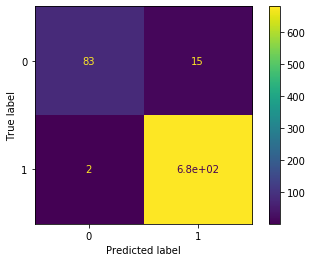

In [38]:
# KNN
knn_model = KNeighborsClassifier()
parameters_knn = {"n_neighbors": [2, 3, 5, 10, 15], "weights": ["uniform", "distance"], "algorithm": ["auto", "ball_tree", "kd_tree"],
                  "leaf_size": [5 ,10, 20, 30, 50]}

grid_knn = GridSearchCV(knn_model, parameters_knn, scoring=make_scorer(precision_score))
grid_knn.fit(X_train, y_train)

knn_model = grid_knn.best_estimator_

knn_acc_t = metrics.accuracy_score(y_train, knn_model.predict(X_train))
print(f'Training Accuracy: {knn_acc_t}')
print('_'*20)
print('Validation Results')
knn_acc, knn_precision, knn_recall, knn_f1 = show_results(knn_model, X_valid, y_valid)

Training Accuracy: 0.9987179487179487
____________________
Validation Results
Accuracy: 0.985897435897436
Precision: 0.9841269841269841
Recall: 1.0
F1: 0.9919999999999999


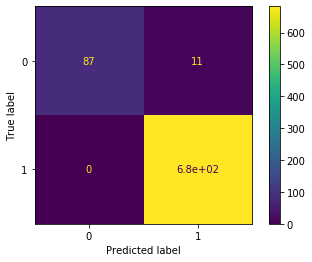

In [39]:
# Random Forest
rf_model = RandomForestClassifier()
parameters_rf = {"n_estimators": [4, 5, 6, 7, 8, 9, 10, 15, 20], "criterion": ["gini", "entropy"], "max_features": ["auto", "sqrt", "log2"], 
                 "max_depth": [2, 3, 5, 10, 15], "min_samples_split": [2, 3, 5, 10, 15]}

grid_rf = GridSearchCV(rf_model, parameters_rf, scoring=make_scorer(accuracy_score))
grid_rf.fit(X_train, y_train)

rf_model = grid_rf.best_estimator_
rf_model.fit(X_train, y_train)

rf_acc_t = metrics.accuracy_score(y_train, rf_model.predict(X_train))
print(f'Training Accuracy: {rf_acc_t}')
print('_'*20)
print('Validation Results')
rf_acc, rf_precision, rf_recall, rf_f1 = show_results(rf_model, X_valid, y_valid)

Training Accuracy: 0.9987179487179487
____________________
Validation Results
Accuracy: 0.9833333333333333
Precision: 0.9826839826839827
Recall: 0.998533724340176
F1: 0.9905454545454545


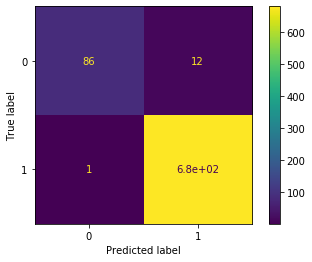

In [40]:
# XGBoost
from xgboost import XGBClassifier

xg_model = XGBClassifier()

parameters_xg = {"n_estimators" : [5, 10, 15, 20]}

grid_xg = GridSearchCV(xg_model, parameters_xg, scoring=make_scorer(precision_score))
grid_xg.fit(X_train, y_train)

xg_model = grid_xg.best_estimator_

xg_acc_t = metrics.accuracy_score(y_train, xg_model.predict(X_train))
print(f'Training Accuracy: {rf_acc_t}')
print('_'*20)
print('Validation Results')
xg_acc, xg_precision, xg_recall, xg_f1 = show_results(xg_model, X_valid, y_valid)

Training Accuracy: 0.9580128205128206
____________________
Validation Results
Accuracy: 0.9294871794871795
Precision: 0.926530612244898
Recall: 0.998533724340176
F1: 0.9611856033874382


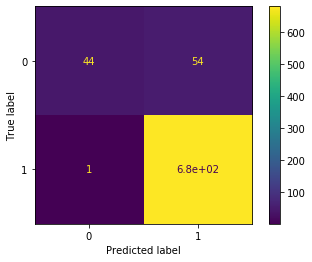

In [41]:
# Decision Tree
tree_model = DecisionTreeClassifier()
parameters_dt = {"criterion": ["gini", "entropy"], "splitter": ["best", "random"], "max_features": ["auto", "sqrt", "log2"], 'max_depth': [3, 5, 7]}

grid_dt = GridSearchCV(tree_model, parameters_dt, scoring=make_scorer(accuracy_score))
grid_dt.fit(X_train, y_train)

tree_model = grid_dt.best_estimator_

tree_acc_t = metrics.accuracy_score(y_train, tree_model.predict(X_train))
print(f'Training Accuracy: {tree_acc_t}')
print('_'*20)
print('Validation Results')
tree_acc, tree_precision, tree_recall, tree_f1 = show_results(tree_model, X_valid, y_valid)

In [42]:
# Model comparison
models = pd.DataFrame({
  'Model': [ 'D.Tree', 'RF', 'SVM', 'kNN', 'XG'], 
  'Train Acc': [tree_acc_t, rf_acc_t, svm_acc_t, knn_acc_t, xg_acc_t],  
  'Accuracy' : [tree_acc, rf_acc, svm_acc, knn_acc, xg_acc],
  'Precision': [tree_precision, rf_precision, svm_precision, knn_precision, xg_precision],
  'recall' : [tree_recall, rf_recall, svm_recall, knn_recall, xg_recall],
  'F1' : [tree_f1, rf_f1, svm_f1, knn_f1, xg_f1]
})

In [44]:
models.sort_values('Accuracy', ascending=False)

,Model,Train Acc,Accuracy,Precision,recall,F1
1,RF,0.998718,0.985897,0.984127,1.000000,0.992000
4,XG,0.991346,0.983333,0.982684,0.998534,0.990545
3,kNN,0.994872,0.978205,0.978417,0.997067,0.987654
0,D.Tree,0.958013,0.929487,0.926531,0.998534,0.961186
2,SVM,1.000000,0.500000,0.465347,0.505376,0.484536


In [45]:
# Saving the rf model
dump(knn_model, open('rf_all.pkl', 'wb'))